In [3]:
!nvidia-smi

Wed Sep  2 05:07:36 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from matplotlib import rc
from matplotlib.ticker import MaxNLocator
from pylab import rcParams
from bs4 import BeautifulSoup

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

!pip install -qq transformers==3.0.0 
!pip install -qq  bert-for-tf2
!pip install -qq sentencepiece

import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
from transformers import TFBertForSequenceClassification, BertConfig

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint

rcParams['figure.figsize'] = 14, 10

%matplotlib inline
%config InlineBackend.figure_format='retina'

import warnings
warnings.filterwarnings("ignore")

import logging
logging.basicConfig(level=logging.ERROR)

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Found GPU at: /device:GPU:0


## Reading Data

In [6]:
# load the data to drive
final_text_data = pd.read_pickle('/content/drive/My Drive/bert_amzn/bert_reviews.pkl')
final_text_data.shape

(40000, 2)

In [31]:
# splitting data into train, cv and test dataset
train_df, test_df = train_test_split(final_text_data, test_size=0.3, random_state=RANDOM_SEED)
train_df, cv_df = train_test_split(final_text_data, test_size=0.2, random_state=RANDOM_SEED)

In [32]:
train_df.reset_index(drop=True, inplace=True)
print(train_df.shape)
train_df.head(3)

(32000, 2)


,text,labels
0,i bought these pill pockets for my boyfriend i...,1
1,this cat food is very delicious that my cat lo...,1
2,i got a bag full of coffee and chocolate beans...,0


In [33]:
train_df.labels.value_counts()

0    16003
1    15997
Name: labels, dtype: int64

In [34]:
test_df.reset_index(drop=True, inplace=True)
print(test_df.shape)
test_df.head(3)

(12000, 2)


,text,labels
0,the noodles were fine it is just the packaged ...,0
1,i found these turkish delights to be unexpecte...,1
2,as someone who loves japanese style green tea ...,0


In [35]:
test_df.labels.value_counts()

1    6000
0    6000
Name: labels, dtype: int64

In [36]:
cv_df.reset_index(drop=True, inplace=True)
print(cv_df.shape)
cv_df.head(3)

(8000, 2)


,text,labels
0,the noodles were fine it is just the packaged ...,0
1,i found these turkish delights to be unexpecte...,1
2,as someone who loves japanese style green tea ...,0


In [37]:
cv_df.labels.value_counts()

1    4003
0    3997
Name: labels, dtype: int64

In [38]:
max_text_length = len(max(final_data["Text"], key=len).split(' '))
max_text_length ## length of the largest text sample from the dataset

2070

In [39]:
f_data = pd.DataFrame()
f_data['len_text'] = final_data['Text'].apply(lambda x: len(x.split()))
f_data = f_data[f_data.len_text > 450]
f_data.shape ## how many text samples are more than 450 in length
## max token length supported by bert is 512 and we have 218 text samples more than 450 words
## we can avoid using truncating and splitting techniques as most of our data is less than 450 words

(218, 1)

## Loading Model

In [40]:
## Loading the bert Model
PRE_TRAINED_MODEL_NAME = 'bert-base-uncased'

In [41]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

## Data preprocessing for Bert Model

In [42]:
max_length = 512 # max tokens supported by bert
batch_size = 8 # select a lower batch_size to avoid running into memory error

In [43]:
# encoding our text data in a format supported by bert
def convert_example_to_feature(review_text):
  encoding = tokenizer.encode_plus(review_text, # text data 
                add_special_tokens = True, # add [CLS], [SEP]
                max_length = max_length, # max length of the text that can go to BERT
                pad_to_max_length = True, # add [PAD] tokens
                return_attention_mask = True, # add attention mask to not focus on pad tokens
                return_token_type_ids=True,
                truncation = True # truncating reviews longer than the max length
              )
  
  return encoding


In [44]:
# map to the expected input to TFBertForSequenceClassification
def map_example_to_dict(input_ids, attention_masks, token_type_ids, label):
  return {
      "input_ids": input_ids,
      "token_type_ids": token_type_ids,
      "attention_mask": attention_masks,
      }, label

def encode_examples(data):

  input_ids_list = []
  token_type_ids_list = []
  attention_mask_list = []
  label_list = []
    
  for review, label in data.to_numpy():

    bert_input = convert_example_to_feature(review)
  
    input_ids_list.append(bert_input['input_ids'])
    token_type_ids_list.append(bert_input['token_type_ids'])
    attention_mask_list.append(bert_input['attention_mask'])
    label_list.append([label])

  return tf.data.Dataset.from_tensor_slices((input_ids_list, attention_mask_list, token_type_ids_list, label_list)).map(map_example_to_dict)


In [45]:
# train dataset
df_train_encoded = encode_examples(train_df).shuffle(train_df.shape[0]).batch(batch_size, drop_remainder=False)

# test dataset
df_test_encoded = encode_examples(test_df).batch(batch_size, drop_remainder=False)

# cv dataset
df_cv_encoded = encode_examples(cv_df).batch(batch_size, drop_remainder=False)

## Bert Model

In [46]:
filepath = '/content/drive/My Drive/bert_amzn/model/model-{epoch:03d}-{accuracy:03f}-{val_accuracy:03f}.h5' 

# save model to restart training if interrupted
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min', save_freq='epoch')

# recommended learning rate for Adam 5e-5, 3e-5, 2e-5
learning_rate = 2e-5

# we will do just 1 epoch for illustration, though multiple epochs might be better as long as we will not overfit the model
number_of_epochs = 3

# for multiclass classification we need to specify the number of class labels in bert
# for binary clasiification specifying the number of class labels is not necessary
config = BertConfig.from_pretrained(PRE_TRAINED_MODEL_NAME, num_labels=2) 

# model initialization
model = TFBertForSequenceClassification.from_pretrained(PRE_TRAINED_MODEL_NAME, config=config)

# choosing Adam optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, epsilon=1e-08)

# we do not have one-hot vectors, we can use sparce categorical cross entropy and accuracy
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

model.summary()


Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  109482240 
_________________________________________________________________
dropout_37 (Dropout)         multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  1538      
Total params: 109,483,778
Trainable params: 109,483,778
Non-trainable params: 0
_________________________________________________________________


## Fitting Model

In [47]:
history = model.fit(df_train_encoded, epochs=number_of_epochs, validation_data=df_cv_encoded, callbacks = [checkpoint])

Epoch 1/3
4000/4000 [==============================] - ETA: 0s - loss: 0.2092 - accuracy: 0.9169
Epoch 00001: val_loss improved from inf to 0.15024, saving model to /content/drive/My Drive/bert_amzn/model/model-001-0.916875-0.939000.h5
4000/4000 [==============================] - 4222s 1s/step - loss: 0.2092 - accuracy: 0.9169 - val_loss: 0.1502 - val_accuracy: 0.9390
Epoch 2/3
4000/4000 [==============================] - ETA: 0s - loss: 0.1014 - accuracy: 0.9645
Epoch 00002: val_loss improved from 0.15024 to 0.14396, saving model to /content/drive/My Drive/bert_amzn/model/model-002-0.964500-0.944750.h5
4000/4000 [==============================] - 4226s 1s/step - loss: 0.1014 - accuracy: 0.9645 - val_loss: 0.1440 - val_accuracy: 0.9448
Epoch 3/3
4000/4000 [==============================] - ETA: 0s - loss: 0.0590 - accuracy: 0.9800
Epoch 00003: val_loss did not improve from 0.14396
4000/4000 [==============================] - 4230s 1s/step - loss: 0.0590 - accuracy: 0.9800 - val_loss: 0

## Accuracy and Loss Plot

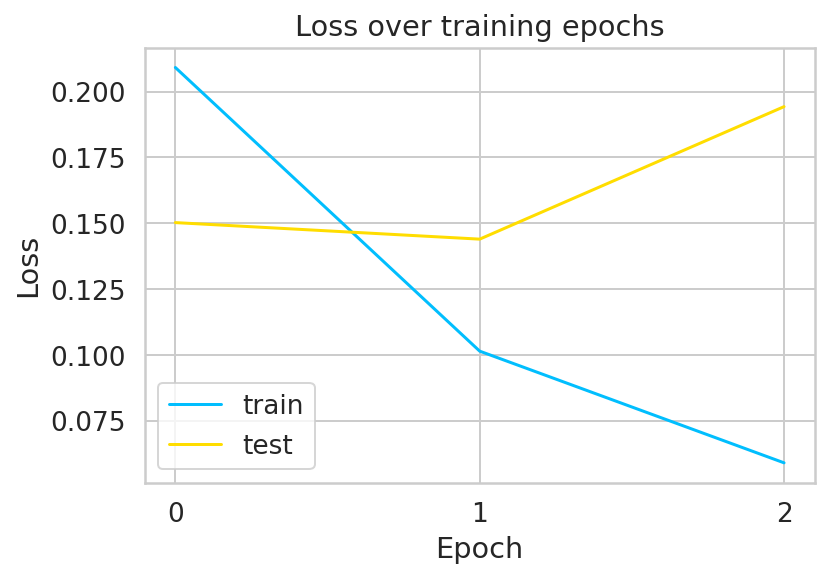

In [101]:
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show();

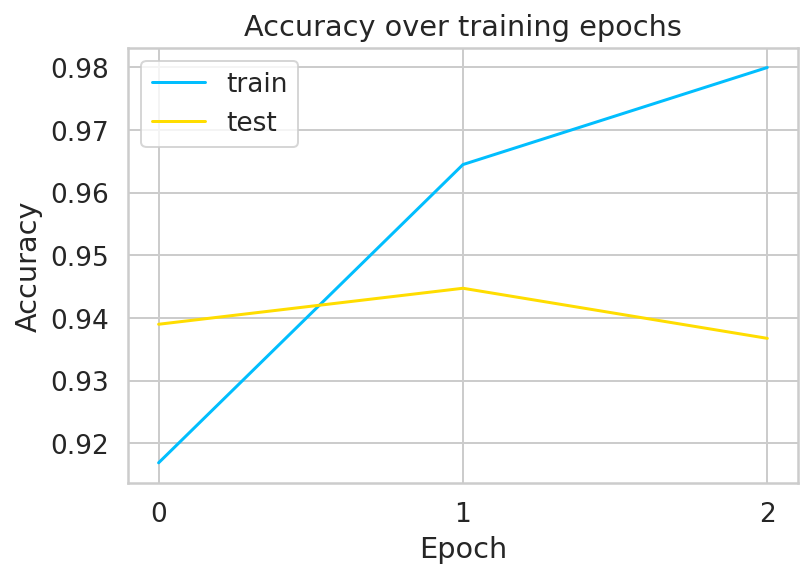

In [104]:
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.plot(history.history['accuracy'])
ax.plot(history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Accuracy over training epochs')
plt.show();

## Evaluating Model on test data

In [ ]:
## load best weights for the model
model.load_weights('/content/drive/My Drive/bert_amzn/model/model-002-0.964500-0.944750.h5')

In [79]:
score = model.evaluate(df_test_encoded)

print('Test score: ', score[0])
print('Test accuracy: ', score[1])

1500/1500 [==============================] - 499s 333ms/step - loss: 0.1085 - accuracy: 0.9598
Test score:  0.10849549621343613
Test accuracy:  0.9598333239555359


In [ ]:
print(classification_report(test_df.labels, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.96      0.96      0.96      6000
    positive       0.96      0.96      0.96      6000

    accuracy                           0.96     12000
   macro avg       0.96      0.96      0.96     12000
weighted avg       0.96      0.96      0.96     12000



## Predictions on test data

In [81]:
predictions = model.predict(df_test_encoded, verbose=1)
y_pred = predictions[0].argmax(axis=-1)

1500/1500 [==============================] - 496s 331ms/step


In [86]:
cm = confusion_matrix(test_df.labels, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)

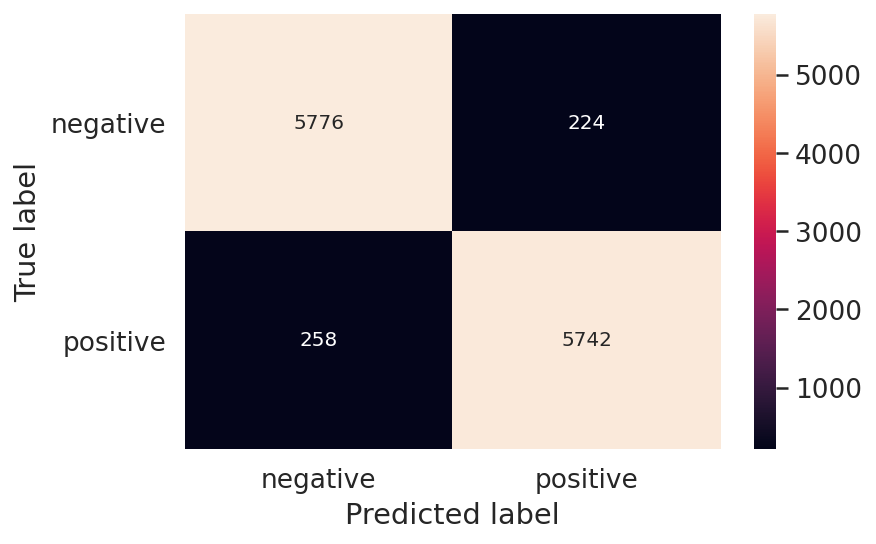

In [112]:
## Confusion matrix
hmap = sns.heatmap(df_cm, annot=True, fmt="d")
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=0, ha='center')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## Predictions on custom text data

In [156]:
#lets test our model on some custom text
review_texts = ['This a very good product and i recommend it to everyone',
                "This a very bad product please don't use it i totally hate it",
                "good product"]

for text in review_texts:
  model_input = convert_example_to_feature(text)  
  input_ids_list.append(model_input['input_ids'])

prediction = model.predict(input_ids_list)[0].argmax(axis=-1)

for text, label in zip(review_texts, prediction):
  print("Text:", text, "\nSentiment:", class_names[label], end='\n\n')

Text: This a very good product and i recommend it to everyone 
Sentiment: positive

Text: This a very bad product please don't use it i totally hate it 
Sentiment: negative

Text: good product 
Sentiment: positive



## Summary

- Here we have used Bert pretrained model for classification of review texts into positive and negative reviews 
- we have used 20000 positive and negative reviews each for classification
- We achieved very High accuracy of 96% on test data
- The model classified all the custom data points perfectly